In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
# Step 1: Load data
bankrupt_data = pd.read_excel('bankrupt_financial_ratio_dataset_final.xlsx')
healthy_data = pd.read_excel('healthy_financial_ratio_dataset _final.xlsx')
vix_data = pd.read_csv('VIX_yearly_means.csv')

# Add target variable
bankrupt_data['Bankruptcy'] = 1
healthy_data['Bankruptcy'] = 0

# Combine datasets
data = pd.concat([bankrupt_data, healthy_data], ignore_index=True)

In [70]:
# Step 2: Merge with VIX data (adjust for column name)
data.rename(columns={'Feature_name': 'Year'}, inplace=True)
data = data.merge(vix_data, on='Year', how='left')

In [71]:
# Step 3: Exploratory Data Analysis
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576 entries, 0 to 3575
Data columns (total 77 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Folder_name   3576 non-null   object 
 1   Year          3576 non-null   int64  
 2   x1            3576 non-null   float64
 3   x2            3576 non-null   float64
 4   x3            3576 non-null   float64
 5   x4            3576 non-null   float64
 6   x5            3576 non-null   float64
 7   x6            3576 non-null   float64
 8   x7            3576 non-null   float64
 9   x8            3164 non-null   float64
 10  x9            3576 non-null   float64
 11  x10           3576 non-null   float64
 12  x11           3576 non-null   float64
 13  x12           3576 non-null   float64
 14  x13           3576 non-null   float64
 15  x14           3576 non-null   float64
 16  x15           3576 non-null   float64
 17  x16           3161 non-null   float64
 18  x17           3576 non-null 

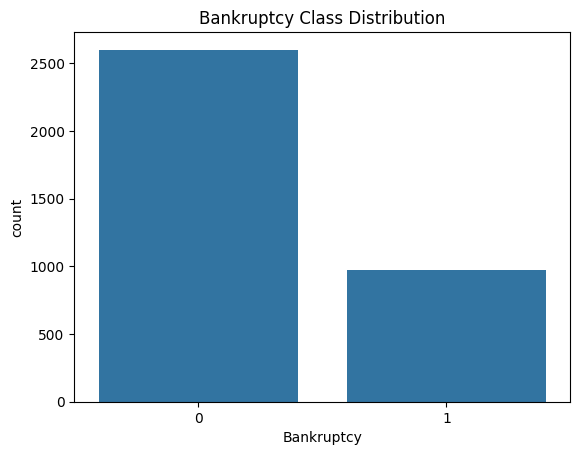

In [72]:
# Visualize target distribution
sns.countplot(x='Bankruptcy', data=data)
plt.title('Bankruptcy Class Distribution')
plt.show()

In [73]:
# Check for missing values
print(data.isnull().sum())

# Handle missing values: Impute with column medians for all numeric columns
for column in data.select_dtypes(include=[np.number]).columns:
    data[column] = data[column].fillna(data[column].median())



Folder_name       0
Year              0
x1                0
x2                0
x3                0
               ... 
Low             189
Close           189
Prev. Close     189
Change          189
% Change        189
Length: 77, dtype: int64


In [74]:
# Feature scaling
features = data.drop(columns=['Bankruptcy', 'Year','Folder_name','Label'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [75]:
# Prepare final dataset
X = pd.DataFrame(scaled_features, columns=features.columns)
y = data['Bankruptcy']


In [76]:
# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Define function to print performance metrics
def print_metrics(model_name, y_test, y_preds, y_probs):
    print(f"{model_name} Performance:")
    print(f"Test Accuracy: {accuracy_score(y_test, y_preds):.4f}")
    print(f"Precision: {precision_score(y_test, y_preds):.4f}")
    print(f"Recall: {recall_score(y_test, y_preds):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_preds):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs):.4f}\n")

In [77]:
# Step 5: Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:, 1]
print_metrics("Logistic Regression", y_test, log_preds, log_probs)

Logistic Regression Performance:
Test Accuracy: 0.9106
Precision: 0.8876
Recall: 0.7692
F1 Score: 0.8242
ROC AUC: 0.9500



In [78]:
# Step 6: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
print_metrics("Random Forest", y_test, rf_preds, rf_probs)

Random Forest Performance:
Test Accuracy: 0.9455
Precision: 0.9149
Recall: 0.8821
F1 Score: 0.8982
ROC AUC: 0.9834



In [79]:
# Step 7: XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
print_metrics("XGBoost", y_test, xgb_preds, xgb_probs)

c:\Users\chira\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
Test Accuracy: 0.9539
Precision: 0.9451
Recall: 0.8821
F1 Score: 0.9125
ROC AUC: 0.9875



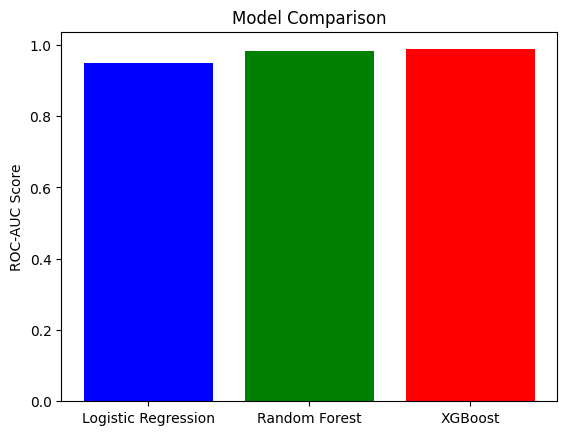

In [80]:
# Step 8: Model Comparison
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
auc_scores = [
    roc_auc_score(y_test, log_probs),
    roc_auc_score(y_test, rf_probs),
    roc_auc_score(y_test, xgb_probs)
]

plt.bar(models, auc_scores, color=['blue', 'green', 'red'])
plt.ylabel('ROC-AUC Score')
plt.title('Model Comparison')
plt.show()


selected_ratios = ["x1", "x4", "x13", "x15", "x26", "x28"]
### Note:- This is without Lagged Features , Rolling statistics and  VIX
## Description of Selected Financial Ratios
The six financial ratios chosen for the model were carefully selected to provide a comprehensive assessment of a company’s financial health. They were chosen because they represent key aspects of financial analysis that are most indicative of bankruptcy risk:

#### 1. Current Ratio (x1)
This ratio evaluates a company’s liquidity by measuring its ability to cover short-term obligations with short-term assets. Companies with liquidity issues often struggle to meet obligations, which is a common precursor to financial distress.

Role in Prediction: Low or declining current ratios are strong indicators of cash flow problems and increased bankruptcy risk.

#### 2. Debt-to-Equity Ratio (x4)
This leverage ratio measures the extent to which a company is financed through debt relative to equity. High leverage increases financial risk, especially during economic downturns.

Role in Prediction: Rising debt-to-equity ratios can signal unsustainable debt levels, making it a critical predictor of financial instability.

#### 3. Total Debt to Total Assets (x13)
This ratio provides another view of leverage by assessing the proportion of a company’s assets financed by debt. It complements the debt-to-equity ratio by focusing on the relationship between debt and total assets.

Role in Prediction: High values of this ratio indicate a company’s heavy reliance on debt to finance its assets, increasing its vulnerability to financial shocks.

#### 4. Asset Turnover Ratio (x15)
This efficiency ratio measures how effectively a company uses its assets to generate sales. Operational inefficiency can signal underlying issues in a company’s business model or management.

Role in Prediction: Declining asset turnover ratios suggest inefficiencies that may lead to lower profitability and higher risk of bankruptcy.

#### 5. Total Liabilities to Total Assets (x26)
This ratio offers a comprehensive view of financial risk by comparing total liabilities to total assets. It captures the extent to which a company’s assets are financed through liabilities.

Role in Prediction: High or increasing values indicate limited financial flexibility and greater risk of insolvency.

#### 6. Return on Investment (ROI) (x28)
ROI measures profitability relative to total invested capital. It reflects how effectively a company is using its financial resources to generate returns.

Role in Prediction: Declining ROI highlights profitability issues, which are a common sign of financial distress and a precursor to bankruptcy.

## Justification for Selected Financial Ratios
#### Comprehensive Coverage of Financial Health:
These six ratios collectively capture key dimensions of financial health:

    Liquidity: Current Ratio (x1)

    Leverage: Debt-to-Equity Ratio (x4) and Total Debt to Total Assets (x13)

    Operational Efficiency: Asset Turnover Ratio (x15)

    Financial Risk: Total Liabilities to Total Assets (x26)

    Profitability: Return on Investment (x28)

#### Proven Relevance to Bankruptcy Risk:
These ratios are well-documented in financial literature as strong predictors of bankruptcy, aligning with frameworks such as Altman’s Z-Score and other financial distress prediction models.

#### Interpretability:
Each ratio is easy to interpret and aligns with fundamental financial analysis principles, making the model’s predictions more explainable to stakeholders.

#### Balance of Risk Indicators:
By including ratios from different categories (liquidity, leverage, efficiency, and profitability), the model can assess multiple risk factors contributing to bankruptcy.


In [81]:
# Selected ratios
selected_ratios = ["x1", "x4", "x13", "x15", "x26", "x28"]

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[selected_ratios])

# Prepare final dataset
X = pd.DataFrame(scaled_features, columns=selected_ratios)
y = data['Bankruptcy']

In [82]:
# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define function to print performance metrics
def print_metrics(model_name, y_test, y_preds, y_probs):
    print(f"{model_name} Performance:")
    print(f"Test Accuracy: {accuracy_score(y_test, y_preds):.4f}")
    print(f"Precision: {precision_score(y_test, y_preds):.4f}")
    print(f"Recall: {recall_score(y_test, y_preds):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_preds):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs):.4f}\n")

In [83]:
# Step 5: Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:, 1]
print_metrics("Logistic Regression", y_test, log_preds, log_probs)

Logistic Regression Performance:
Test Accuracy: 0.8338
Precision: 0.8878
Recall: 0.4462
F1 Score: 0.5939
ROC AUC: 0.8905



In [84]:
# Step 6: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
print_metrics("Random Forest", y_test, rf_preds, rf_probs)

Random Forest Performance:
Test Accuracy: 0.8911
Precision: 0.8268
Recall: 0.7590
F1 Score: 0.7914
ROC AUC: 0.9493



In [85]:
# Step 7: XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
print_metrics("XGBoost", y_test, xgb_preds, xgb_probs)

XGBoost Performance:
Test Accuracy: 0.8911
Precision: 0.8031
Recall: 0.7949
F1 Score: 0.7990
ROC AUC: 0.9510



c:\Users\chira\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


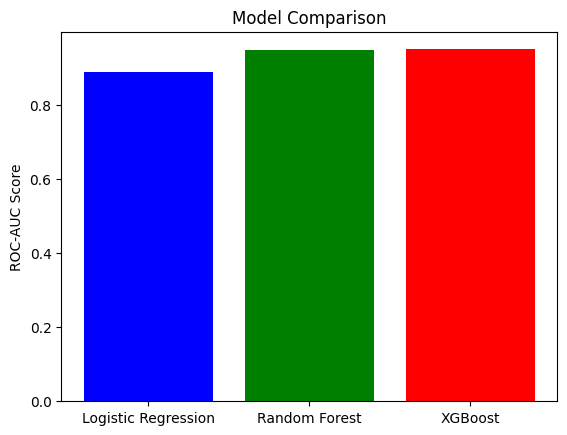

In [86]:
# Step 8: Model Comparison
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
auc_scores = [
    roc_auc_score(y_test, log_probs),
    roc_auc_score(y_test, rf_probs),
    roc_auc_score(y_test, xgb_probs)
]

plt.bar(models, auc_scores, color=['blue', 'green', 'red'])
plt.ylabel('ROC-AUC Score')
plt.title('Model Comparison')
plt.show()
